<a href="https://colab.research.google.com/github/Danil1D/KSVD/blob/main/%D0%94%D0%B0%D1%88%D0%BA%D0%B5%D0%B2%D0%B8%D1%87_%D0%BB%D0%B0%D0%B1_1_%D0%B7%D0%B0%D0%B2_%E2%84%961.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trial 5 Complete [00h 00m 09s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 43s
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1250 - loss: 2.4897 - val_accuracy: 0.0000e+00 - val_loss: 2.4894
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.1250 - loss: 2.4716 - val_accuracy: 0.0000e+00 - val_loss: 2.4924
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5000 - loss: 2.4530 - val_accuracy: 0.0000e+00 - val_loss: 2.4971
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8750 - loss: 2.4299 - val_accuracy: 0.0000e+00 - val_loss: 2.5046
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5000 - loss: 2.4144 - val_accuracy: 0.0000e+00 - val_loss: 2.5149
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6250 - loss: 2.3847 - val_accuracy: 0.0000e+00 - val_loss: 2.5271
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6250 - loss: 2.3440 - val_accuracy: 0.0000e+00 

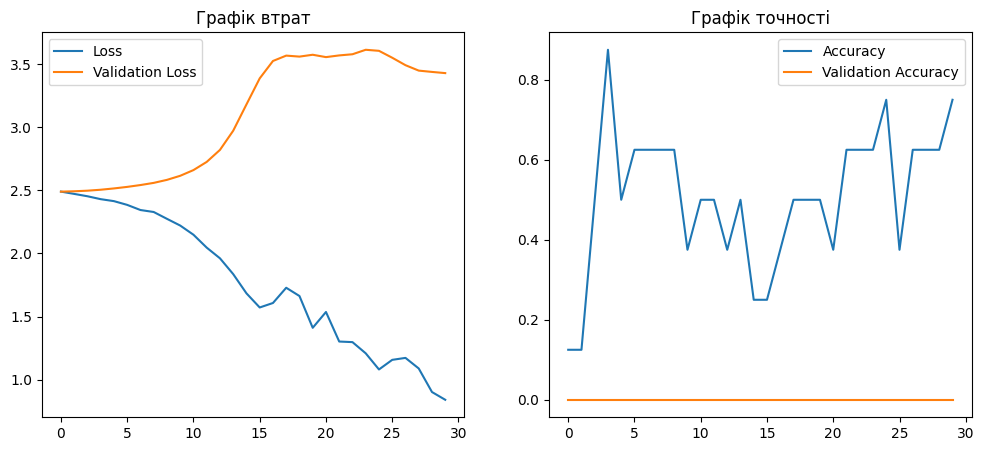

In [ ]:
!pip install tensorflow keras-tuner
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, GRU, Dropout
    import numpy as np
    import matplotlib.pyplot as plt
    from kerastuner.tuners import RandomSearch
except ModuleNotFoundError:
    raise ModuleNotFoundError("TensorFlow is not installed. Please install it using 'pip install tensorflow keras-tuner'.")

# Зразок текстових даних
text = "Машинне навчання - це метод аналізу даних, який автоматизує побудову аналітичних моделей."

# Токенізація тексту
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1

# Підготовка послідовностей
input_sequences = []
words = text.split()
for i in range(1, len(words)):
    seq = tokenizer.texts_to_sequences([words[:i+1]])[0]
    input_sequences.append(seq)

# Доповнення послідовностей
max_length = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_length, padding='pre')
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = keras.utils.to_categorical(y, num_classes=vocab_size)

# Функція для побудови моделі
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Int('embedding_dim', 32, 128, step=32), input_length=max_length-1))
    model.add(GRU(units=hp.Int('rnn_units', 64, 256, step=64), return_sequences=False, dropout=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Використання Keras Tuner для підбору гіперпараметрів
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_results',
    project_name='rnn_word_prediction'
)

# Запуск підбору гіперпараметрів
tuner.search(X, y, epochs=20, validation_split=0.2)

# Отримання найкращих гіперпараметрів
best_hps = tuner.get_best_hyperparameters(num_trials=1)
if not best_hps:
    raise ValueError("Не вдалося знайти найкращі гіперпараметри. Переконайтеся, що tuner.search() виконано коректно.")

best_model = tuner.hypermodel.build(best_hps[0])
history = best_model.fit(X, y, epochs=30, validation_split=0.2)

# Побудова графіків втрат і точності
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Графік втрат')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Графік точності')

plt.show()
